![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+GenAI%2FGenerate&file=Create+Files+For+Multimodal+Prompt+Examples.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Generate/Create%20Files%20For%20Multimodal%20Prompt%20Examples.ipynb">
      <img width="32px" src="https://www.svgrepo.com/download/217753/github.svg" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Generate/Create%20Files%20For%20Multimodal%20Prompt%20Examples.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520GenAI%2FGenerate%2FCreate%2520Files%2520For%2520Multimodal%2520Prompt%2520Examples.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/bigquery/import?url=https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Generate/Create%20Files%20For%20Multimodal%20Prompt%20Examples.ipynb">
      <img width="32px" src="https://www.gstatic.com/images/branding/gcpiconscolors/bigquery/v1/32px.svg" alt="BigQuery logo">
      <br>Open in<br>BigQuery Studio
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20GenAI/Generate/Create%20Files%20For%20Multimodal%20Prompt%20Examples.ipynb">
      <img width="32px" src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Create Files For Multimodal Prompt Examples

This notebook makes example audio, video, image, and pdf content for other workflows in this series: [Applied GenAI](./Applied%20GenAI/readme.md).

The files are used for the examples in the [Vertex AI Gemini API](./Vertex%20AI%20Gemini%20API.ipynb) workflow.

---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

Not a Colab Environment


---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [3]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform', '1.69.0'),
    ('google.cloud.texttospeech', 'google-cloud-texttospeech'),
    ('numpy', 'numpy'),
    ('matplotlib', 'matplotlib'),
    ('pdfkit', 'pdfkit')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### API Enablement

In [4]:
!gcloud services enable aiplatform.googleapis.com
!gcloud services enable texttospeech.googleapis.com

### System Installs

In [5]:
#!sudo apt-get install -y ffmpeg

In [6]:
#!sudo apt-get install -y wkhtmltopdf

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [7]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

inputs:

In [8]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [9]:
REGION = 'us-central1'
SERIES = 'applied-genai'
EXPERIMENT = 'multimodal-inputs'

packages:

In [10]:
import os, io, base64, re, asyncio

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
#from IPython.display import Markdown, HTML, IFrame, Video, Image, Audio
import IPython.display as display

import pdfkit

from google.cloud import texttospeech
from google.cloud import aiplatform
import vertexai
import vertexai.generative_models # for Gemini Models

In [11]:
aiplatform.__version__

'1.78.0'

clients:

In [12]:
vertexai.init(project = PROJECT_ID, location = REGION)
tts = texttospeech.TextToSpeechClient()

Parameters:

In [13]:
DIR = f"files/{EXPERIMENT}"

Environment:

In [14]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

---
## Create Image

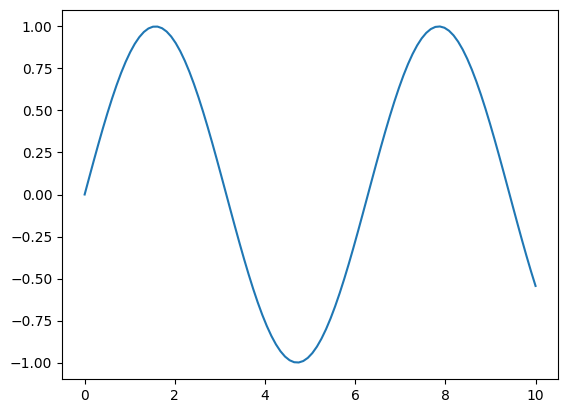

In [15]:
x = np.linspace(0, 10, 100)
y = np.sin(x)
plt.plot(x, y)

buffer = io.BytesIO()
plt.savefig(buffer, format = 'png')
plot_bytes = buffer.getvalue()

# Save 
plt.savefig(f'{DIR}/plot.jpeg', format='jpeg')
plt.savefig(f'{DIR}/plot.png', format='png')
plt.savefig(f'{DIR}/plot.webp', format='webp')

plt.show()

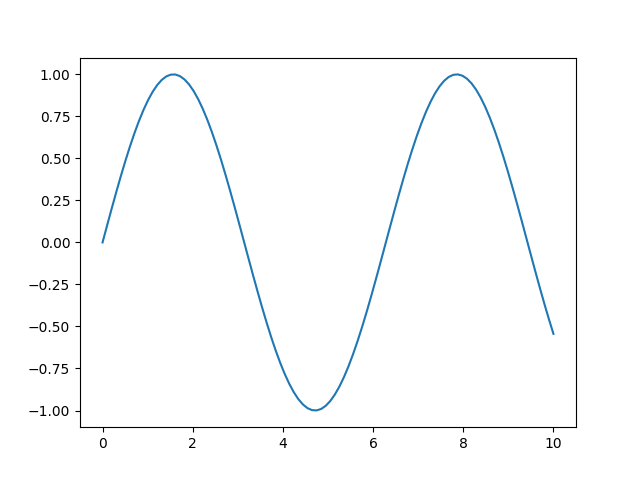

In [16]:
display.Image(f'{DIR}/plot.png')

---
## Create Video

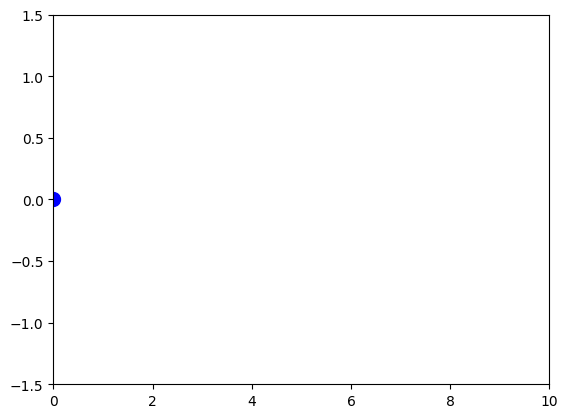

In [17]:
# Initialize the plot
fig, ax = plt.subplots()

# Set the x and y axis limits
ax.set_xlim(0, 10)  # Adjust the x-axis range if needed
ax.set_ylim(-1.5, 1.5)  # Adjust the y-axis range if needed

# Create the blue circle
circle = plt.scatter(x[0], y[0], s=100, c='blue')

# Animation update function
def animate(i):
    circle.set_offsets([x[i], y[i]])
    return circle,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=len(x), interval=50)

# Save the animation as an MP4 file
writer = animation.FFMpegWriter(fps=30, codec='libx264')
ani.save(f'{DIR}/video.mp4', writer=writer)

# Embed the animation in the notebook
#plt.clf()
#display.HTML(ani.to_jshtml())

In [18]:
display.Video(f"{DIR}/video.mp4", embed=True)

---
## Create Audio

Use llm to get description of sin curve.  Then use TTS to create audio.

- [Cloud Text-to-Speech Client Libraries](https://cloud.google.com/text-to-speech/docs/create-audio-text-client-libraries)

In [19]:
gemini = vertexai.generative_models.GenerativeModel("gemini-1.5-flash-002")

In [20]:
response = gemini.generate_content('I need a detailed description of the sine curve, sin function, with history and interpretation.')

In [21]:
display.Markdown(response.text)

## The Sine Curve: A Detailed Description

The sine curve, a graphical representation of the sine function, is a fundamental concept in mathematics, physics, and engineering. Its undulating, wave-like nature describes cyclical phenomena across numerous disciplines.

**1. The Sine Function (sin x):**

Mathematically, the sine function, denoted as sin(x), is a trigonometric function that relates an angle of a right-angled triangle to the ratio of the length of the side opposite to the angle and the length of the hypotenuse.  However, its definition extends beyond right-angled triangles to encompass all real numbers (and even complex numbers) through the unit circle interpretation.

* **Right-angled triangle definition:**  In a right-angled triangle with an angle x, sin(x) = opposite/hypotenuse.

* **Unit circle definition:** Consider a unit circle (radius 1) centered at the origin of a coordinate system.  Let x be an angle measured counterclockwise from the positive x-axis. The y-coordinate of the point where the terminal side of the angle intersects the circle is sin(x).  This definition allows for angles greater than 90 degrees and negative angles.

**2. Properties of the Sine Curve:**

The graph of y = sin(x) exhibits several key characteristics:

* **Periodicity:** The sine function is periodic with a period of 2π radians (or 360 degrees). This means the curve repeats itself every 2π units along the x-axis.  sin(x + 2π) = sin(x) for all x.

* **Amplitude:** The amplitude of the sine curve is 1. This represents the maximum distance the curve reaches from its horizontal midline (the x-axis).

* **Range:** The range of the sine function is [-1, 1].  The y-values of the curve never exceed 1 or fall below -1.

* **Domain:** The domain of the sine function is all real numbers (-∞, ∞).  You can input any real number into the sine function.

* **Symmetry:** The sine function is an odd function, meaning sin(-x) = -sin(x). This manifests as symmetry about the origin.

* **Zeros:** The sine function has zeros at multiples of π (i.e., x = nπ, where n is an integer). These are the points where the curve crosses the x-axis.

* **Maximum and Minimum Values:** The sine function reaches its maximum value of 1 at x = π/2 + 2nπ and its minimum value of -1 at x = 3π/2 + 2nπ, where n is an integer.


**3. Transformations of the Sine Curve:**

The basic sine curve, y = sin(x), can be transformed by altering its amplitude, period, phase shift, and vertical shift:

* **Amplitude (A):** y = A sin(x) stretches or compresses the curve vertically.  |A| is the amplitude.

* **Period (P):** y = sin(Bx) changes the period to P = 2π/|B|.  A larger |B| results in a shorter period (more compressed curve).

* **Phase Shift (C):** y = sin(x - C) shifts the curve horizontally by C units. A positive C shifts the curve to the right, and a negative C shifts it to the left.

* **Vertical Shift (D):** y = sin(x) + D shifts the curve vertically by D units.


**4. History of the Sine Function:**

The origins of the sine function can be traced back to ancient civilizations.  While not explicitly defined as we know it today, the concept of the sine ratio appeared in various forms:

* **Babylonian mathematics (around 1800 BC):**  Used tables of chords in circles, which are related to the sine function.

* **Ancient Greek mathematics (around 200 BC):** Hipparchus and Ptolemy developed trigonometric tables that essentially represented sine values.  However, they used chords rather than the sine ratio directly.

* **Indian mathematics (around 500 AD):** Indian mathematicians, particularly Aryabhata, developed sophisticated trigonometric techniques and explicitly defined the sine function (jya), which later influenced Islamic mathematicians.

* **Islamic Golden Age (around 800-1200 AD):**  Islamic mathematicians refined and expanded trigonometric knowledge, translating and building upon the work of Indian and Greek scholars.  They developed more accurate sine tables and introduced the concept of sine as a function rather than just a table entry.

* **European Renaissance (around 1500-1700 AD):** European mathematicians further developed and formalized trigonometry, including the sine function, leading to its modern mathematical notation and widespread use in various fields.


**5. Interpretations of the Sine Curve:**

The sine curve's ability to model periodic phenomena makes it incredibly versatile.  Its applications include:

* **Physics:**  Describing simple harmonic motion (e.g., pendulum oscillations, spring vibrations, waves on a string).
* **Engineering:**  Analyzing alternating current (AC) electricity, designing filters and oscillators in electronics, modeling vibrations in structures.
* **Signal Processing:**  Representing and manipulating sound waves, light waves, and other signals.
* **Biology:**  Modeling biological rhythms (e.g., circadian rhythms, population oscillations).
* **Economics:**  Modeling cyclical economic trends.
* **Computer Graphics:**  Generating smooth curves and animations.


In essence, the sine curve is more than just a mathematical function; it's a powerful tool for understanding and representing the cyclical nature of the world around us. Its historical development reflects the collaborative and evolving nature of scientific progress across different cultures and eras.


In [22]:
script = response.text.encode('utf-8')[0:5000].decode('utf-8')

In [23]:
synth = texttospeech.SynthesisInput(text = script)
voice =texttospeech.VoiceSelectionParams(language_code = "en-us", name = 'en-US-Wavenet-A')
audio = texttospeech.AudioConfig(audio_encoding = texttospeech.AudioEncoding.MP3)
response = tts.synthesize_speech(input = synth, voice = voice, audio_config=audio)
with open(f"{DIR}/audio.mp3", "wb") as out:
  out.write(response.audio_content)

In [24]:
display.Audio(filename = f"./{DIR}/audio.mp3")

---
## Create PDF

In [15]:
gemini = vertexai.generative_models.GenerativeModel("gemini-1.5-flash-002")

In [20]:
#response = gemini.generate_content('Create an example invoice template.  Respond in HTML')
response = gemini.generate_content('I am working on a project where I am creating some sample files for a project for a customer.  I am creating a plot providing it as .png, .jpeg, and .webp format.  I am creating a video animation of the plot as a .mp4.  I am also writing a script that describes the process in the plot and animation.  The script is converted to an audio file, .mp3, to provide the customer also.  Finally, I need to create an invoice file for the customer.  Can you create an example invoice for this in HTML format?  Fill in an example company name and contact info for this. Include an invoice number.')

In [21]:
pattern = r'```(?:html|HTML)\n(.*?)```'  # Matches HTML code blocks
matches = re.search(pattern, response.text, re.DOTALL)

In [22]:
if matches:
    invoice_html = matches.group(1).strip()
else:
    invoice_html = "<!DOCTYPE html><html><head><title>Error</title></head><body><h1>Something didn't work.</h1><p>Please try again.</p></body></html>"

In [23]:
display.HTML(invoice_html)

In [24]:
pdfkit.from_string(invoice_html, f'{DIR}/invoice.pdf')

True

In [25]:
display.IFrame(f'{DIR}/invoice.pdf', width=800, height= 800)

---
## Create PDFs - Many versions of The Invoice

Use the generated invoice above to create many invoices

In [58]:
gemini = vertexai.generative_models.GenerativeModel("gemini-2.0-flash-001")

In [59]:
with open(f"{DIR}/invoice.pdf", 'rb') as f:
    document_read = f.read()

In [60]:
document_inline = vertexai.generative_models.Part.from_data(
    data = base64.b64encode(document_read).decode('utf_8'),
    mime_type = 'application/pdf'
)

In [66]:
responses = await asyncio.gather(*[
    gemini.generate_content_async(
        contents = [
            document_inline,
            'I need to create a sample invoice like the one provided.  The line items could be all or a subset of the one here and the quantities and cost can also change.  Use my company named, Mike Demos, and fill in the address, contact info, and dates with example values.',
            'Create the sample invoices in HTML format.',
            'The layout can change to any commmon invoice layout but no images please.'
        ],
        generation_config = vertexai.generative_models.GenerationConfig(
            candidate_count = 8,
            temperature = 2
        )
    ) for i in range(50)
])

In [67]:
invoices = []
pattern = r'```(?:html|HTML)\n(.*?)```'  # Matches HTML code blocks
for response in responses:
    for candidate in response.candidates:
        try:
            matches = re.search(pattern, candidate.text, re.DOTALL)
            if matches:
                invoice_html = matches.group(1).strip()
                invoices.append(invoice_html)
            else:
                #invoice_html = "<!DOCTYPE html><html><head><title>Error</title></head><body><h1>Something didn't work.</h1><p>Please try again.</p></body></html>"
                print('A candidate was not a match')
            
        except Exception:
            pass

In [68]:
len(invoices)

400

In [69]:
body_content = []
for html in invoices:
    start_match = re.search(r"<body.*?>", html, re.IGNORECASE)
    if start_match:
        start = start_match.end()
        end = html.lower().find("</body>")
        if end != -1:
            body_content.append(html[start:end])
        else:
            print(f"Warning: No closing </body> tag found in: {html}")
            #Handle cases where the </body> tag is missing
            body_content.append(html[start:]) #Take everything to the end
    else:
        print(f"Warning: no <body> tag found {html}")
        #Handle the cases where the <body> tag is missing entirely
        body_content.append(html) # Add entire content, can't find start.

# --- Page Break Implementation ---
# Join the body content with a div styled for page breaks.
html_content = "".join(
    [f'<div style="page-break-after: always;">{content}</div>' for content in body_content]
)


final_html = f"""
<!DOCTYPE html>
<html>
<head>
  <title>Invoices</title>
</head>
<body>
{html_content}
</body>
</html>
"""

In [70]:
pdfkit.from_string(final_html, f'{DIR}/invoices.pdf')

True

In [71]:
display.IFrame(f'{DIR}/invoices.pdf', width=800, height= 800)